**Tech Challenge 3: Arquitetura ML e Aprendizado**

*Problema a ser resolvido*

Identificar a correlação entre dados de usuário (idade, gênero, nacionalidade, ocupação) e preferência por filmes e sua avaliação.
A partir desse modelo, seré criada uma API que poderá receber dois inputs difentes:

1. Dados pertencentes a uma pessoa (idade, gênero, nacionalidade) e partir deles e do modelo treinado ser capaz de sugerir filmes em que poderiam potencialmente ter interesse.

2. Dados relacionados a um filmes (tempo de duração, gêneros, ano de lançamento) e partir deles e do modelo treinado ser capaz de indicar o grupo de maior interesse, para que um time de marketing, por exemplo saiba pra onde direcionar as campanhas

*Conjunto de Dados*

Usaremos o grupo de dados do Movielens para esse caso de estudo (https://files.grouplens.org/datasets/movielens/)

In [70]:
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     -------------------------------------- 60.8/60.8 kB 802.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 22.0 MB/s eta 0:00:01
   --------- ------------------------------ 2.6/11.0 MB 33.2 MB/s eta 0:00:01
   ---------------- ----------------------- 4.6/11.0 MB 33.1 MB/s eta 0:00:01
   ----------------------- ---------------- 6.5/11.0 MB 34.7 MB/s eta 0:00:01
   ------------------------------- -------- 8.5/11.0 MB 38.9 MB/s eta 0:00:01
   -------------------------------------- - 10.6/11.0 MB 40.9 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 36.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   --------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
   ---


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import zipfile
import re
from sklearn.preprocessing import MultiLabelBinarizer

In [40]:
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [41]:
user_data = pd.read_csv('dataset/ml-1m/users.dat',sep='::',header=None,names=['userid','gender','age','occupation','zipcode'],encoding='iso-8859-2')
movie_data = pd.read_csv('dataset/ml-1m/movies.dat',sep='::',header=None,names=['movieid','title','genres'],encoding='iso-8859-2')
ratings_data = pd.read_csv('dataset/ml-1m/ratings.dat',sep='::',header=None,usecols=[0,1,2],names=['userid','movieid','rating'],encoding='iso-8859-2')


C:\Users\hugov\AppData\Local\Temp\ipykernel_29656\4052381238.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  user_data = pd.read_csv('dataset/ml-1m/users.dat',sep='::',header=None,names=['userid','gender','age','occupation','zipcode'],encoding='iso-8859-2')
C:\Users\hugov\AppData\Local\Temp\ipykernel_29656\4052381238.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movie_data = pd.read_csv('dataset/ml-1m/movies.dat',sep='::',header=None,names=['movieid','title','genres'],encoding='iso-8859-2')
C:\Users\hugov\AppData\Local\Temp\ipykernel_29656\4052381238.py:3: ParserWarning: Falling back to the 'p

Ao analisar os dados, podemos perceber que possuímos um ratio desbalanceado entre usuários homens (M) e usuárias mulheres (F).

<Axes: ylabel='count'>

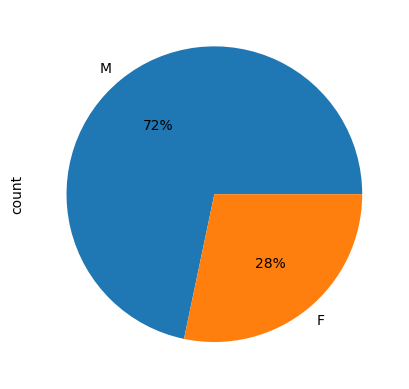

In [42]:
user_data['gender'].value_counts().plot(kind='pie', autopct='%1.0f%%')

Antes de prosseguirmos uma outra informação que é interessante de analisarmos é a distribuição etária de nossos usuários. Vale a pena resaltar que a coluda idade (age) já está "normalizada", obedecendo a seguinte proporção:
*  1:  Mais novos que 18 anos
* 18:  18-24 anos
* 25:  25-34 anos
* 35:  35-44 anos
* 45:  45-49 anos
* 50:  50-55 anos
* 56:  56+ anos

array([<Axes: title={'center': 'F'}, ylabel='Frequency'>,
       <Axes: title={'center': 'M'}, ylabel='Frequency'>], dtype=object)

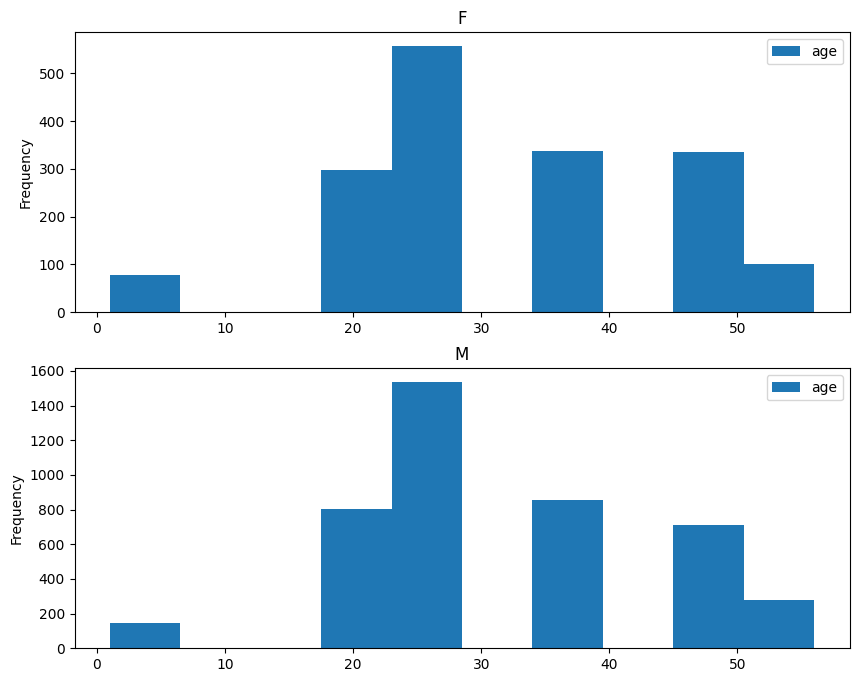

In [43]:
user_data.plot.hist(column=["age"], by="gender", figsize=(10, 8))

**"Mergeando" os datasets**

Antes de começarmos a testar quais modelos podem nos ajudar a solucionar o nosso problema, ou até mesmo antes de padronizarmos/tratarmos os nossos dados, iremos criar um quarto Dataset, que irá conter o todo do cenário com o qual pretendemos trabalhar

In [63]:
dados_completos = pd.merge(user_data, ratings_data, on='userid')
dados_completos = pd.merge(dados_completos, movie_data, on='movieid')
dados_completos.head()

,userid,gender,age,occupation,zipcode,movieid,rating,title,genres
0,1,F,1,10,48067,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,F,1,10,48067,661,3,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,F,1,10,48067,914,3,My Fair Lady (1964),Musical|Romance
3,1,F,1,10,48067,3408,4,Erin Brockovich (2000),Drama
4,1,F,1,10,48067,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [64]:
dados_completos["release_year"] = [int(re.search(r'\((\d{4})\)', x).group(1)) for x in dados_completos["title"]]

Ao analisarmos os dados,mais precisamente a coluna *genres*, é possível perceber que temos um problema de 'Multi-Label' nos nossos dados, onde um filme pode pertencer a 1 ou N gêneros de filmes. Para contornarmos essa situação, iremos converter essa coluna para uma lista de string:

In [65]:
dados_completos['genres'] = dados_completos["genres"].str.split("|")
dados_completos.head()

Em seguida, utilizaremos o **MultiLabelBinarizer** para transformar essa coluna em uma matriz binária

In [73]:
mlb = MultiLabelBinarizer()
encoded_data = mlb.fit_transform(dados_completos['genres'])
dados_encodados = pd.DataFrame(encoded_data,columns=mlb.classes_)

dados_encodados.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


E finalmente concatenaremos esse novo dataframe ao "original", podendo assim excluir a coluna '*genres*' de nossos dados.

In [74]:
dados_completos = pd.concat([dados_completos,dados_encodados],axis=1)
dados_completos = dados_completos.drop(['genres'],axis=1)
dados_completos.head()

,userid,gender,age,occupation,zipcode,movieid,rating,title,release_year,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,1193,5,One Flew Over the Cuckoo's Nest (1975),1975,0,...,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,661,3,James and the Giant Peach (1996),1996,0,...,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,914,3,My Fair Lady (1964),1964,0,...,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,3408,4,Erin Brockovich (2000),2000,0,...,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,2355,5,"Bug's Life, A (1998)",1998,0,...,0,0,0,0,0,0,0,0,0,0
